Loaded obj_1/urdf/obj_1.urdf with base pose (0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 1.0)
Loaded obj_2/urdf/obj_2.urdf with base pose (0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 1.0)
Loaded obj_3/urdf/obj_3.urdf with base pose (0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 1.0)
Loaded obj_4/urdf/obj_4.urdf with base pose (0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 1.0)
Loaded obj_5/urdf/obj_5.urdf with base pose (0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 1.0)
Loaded obj_6/urdf/obj_6.urdf with base pose (0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 1.0)
Moved piece-0 from (0.0, 0.0, 0.0) to (0.25, 0.0, 0.05)


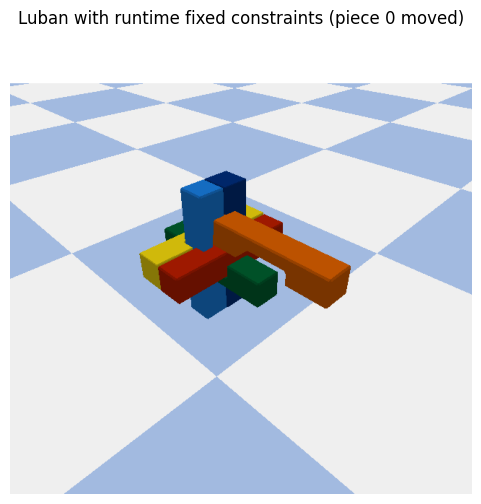

In [ ]:
from __future__ import annotations
from pathlib import Path
import numpy as np
import pybullet as p
import pybullet_data
import matplotlib.pyplot as plt

# ==== 配置 ====
# URDF_ROOT = Path(
#     "/Users/lanyihuai/Documents/GitHub/VisualReasonBench/src/phyvpuzzle/environment/phobos_models/luban-6-piece"
# )
URDF_ROOT = Path(
    "src/phyvpuzzle/environment/phobos_models/luban-6-piece"
)
USE_GUI   = True     # True = GUI窗口, False = 离屏渲染
GRAVITY   = 0.0
DAMPING   = 1.0
MOVE_DEMO = True      # 是否演示移动第0块

# ==== 工具函数 ====
def collect_urdf_files(root: Path) -> list[Path]:
    if not root.exists():
        raise FileNotFoundError(root)
    cand = sorted(root.glob("obj_*/urdf/*.urdf"))
    if not cand:
        cand = sorted(root.rglob("*.urdf"))
    return cand


class RuntimeAssembly:
    """每块独立刚体，用 fixed 约束焊到一个“基准体”，需要时可解约束移动某块。"""

    def __init__(self):
        # 创建基准体（质量0、不可见）
        self.base_id = p.createMultiBody(
            baseMass=0,
            baseCollisionShapeIndex=-1,
            baseVisualShapeIndex=-1,
        )
        self.piece_ids: list[int] = []
        self.piece_names: list[str] = []
        self.constraints: dict[int, int] = {}  # uid -> cid

    def add_piece(self, urdf_path: Path):
        # 关键：所有件都用 basePosition=(0,0,0) 加载
        uid = p.loadURDF(str(urdf_path), basePosition=[0, 0, 0],
                         baseOrientation=[0, 0, 0, 1], useFixedBase=False)
        p.resetBaseVelocity(uid, [0, 0, 0], [0, 0, 0])
        p.changeDynamics(uid, -1, linearDamping=DAMPING, angularDamping=DAMPING)

        self.piece_ids.append(uid)
        self.piece_names.append(urdf_path.stem)

        # 当前 base 位姿（一般就是(0,0,0)，但写成通用形式）
        pos, orn = p.getBasePositionAndOrientation(uid)
        self.attach_to_base(uid, pos, orn)
        return uid

    def attach_to_base(self, uid: int, world_pos, world_orn):
        # 先移除旧约束
        cid_old = self.constraints.pop(uid, None)
        if cid_old is not None:
            p.removeConstraint(cid_old)

        cid = p.createConstraint(
            parentBodyUniqueId=self.base_id, parentLinkIndex=-1,
            childBodyUniqueId=uid, childLinkIndex=-1,
            jointType=p.JOINT_FIXED, jointAxis=[0, 0, 0],
            parentFramePosition=world_pos,
            parentFrameOrientation=world_orn,
            childFramePosition=[0, 0, 0],
            childFrameOrientation=[0, 0, 0, 1],
        )
        self.constraints[uid] = cid

    def detach(self, uid: int):
        cid = self.constraints.pop(uid, None)
        if cid is not None:
            p.removeConstraint(cid)

    def move_piece(self, uid: int, new_pos, new_orn, reattach=True):
        """解焊→移动→可选再焊回。new_orn 为四元数。"""
        self.detach(uid)
        p.resetBasePositionAndOrientation(uid, new_pos, new_orn)
        if reattach:
            self.attach_to_base(uid, new_pos, new_orn)


# ==== 主流程 ====
def main():
    urdf_paths = collect_urdf_files(URDF_ROOT)
    if not urdf_paths:
        raise RuntimeError("No URDFs found under URDF_ROOT.")

    mode = p.GUI if USE_GUI else p.DIRECT
    cid = p.connect(mode)
    p.resetSimulation()
    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.setGravity(0, 0, GRAVITY)

    # 地面
    plane_id = p.loadURDF("plane.urdf")
    p.changeDynamics(plane_id, -1, linearDamping=DAMPING, angularDamping=DAMPING)

    asm = RuntimeAssembly()

    init_poses = []
    for path in urdf_paths:
        uid = asm.add_piece(path)
        pos, orn = p.getBasePositionAndOrientation(uid)
        init_poses.append((uid, pos, orn))
        print(f"Loaded {path.relative_to(URDF_ROOT)} with base pose {pos} {orn}")

    # ======= 在这里移动其中一个小物体 =======
    if MOVE_DEMO and asm.piece_ids:
        uid0, pos0, orn0 = init_poses[0]

        # 把 0 号块沿 +X 拉出 0.25m，并稍微抬高 0.05m 方便看清
        new_pos = (pos0[0] + 0.25, pos0[1], pos0[2] + 0.05)
        asm.move_piece(uid0, new_pos, orn0, reattach=True)

        print(f"Moved piece-0 from {pos0} to {new_pos}")

    # ===== 离屏渲染（DIRECT模式） =====
    if mode == p.DIRECT:
        # 用所有刚体的 AABB 估计场景包围盒（包含已经移动的那块）
        if asm.piece_ids:
            mins, maxs = [], []
            for uid in asm.piece_ids:
                aabb_min, aabb_max = p.getAABB(uid, -1)
                mins.append(aabb_min)
                maxs.append(aabb_max)
            mins = np.min(np.array(mins), axis=0)
            maxs = np.max(np.array(maxs), axis=0)
        else:
            mins = np.array([-0.1, -0.1, 0.0])
            maxs = np.array([0.1, 0.1, 0.2])

        center = 0.5 * (mins + maxs)
        span = float(np.max(maxs - mins))
        dist = max(0.8, 0.6 + span)

        view_matrix = p.computeViewMatrixFromYawPitchRoll(
            cameraTargetPosition=center.tolist(),
            distance=dist,
            yaw=45,
            pitch=-35,
            roll=0,
            upAxisIndex=2,
        )
        projection_matrix = p.computeProjectionMatrixFOV(
            fov=60,
            aspect=1.0,
            nearVal=0.01,
            farVal=5.0,
        )
        w, h, rgba, *_ = p.getCameraImage(
            width=640,
            height=640,
            viewMatrix=view_matrix,
            projectionMatrix=projection_matrix,
            renderer=p.ER_BULLET_HARDWARE_OPENGL,
        )
        rgb = np.array(rgba, dtype=np.uint8).reshape(h, w, 4)[..., :3]
        plt.figure(figsize=(6, 6))
        plt.imshow(rgb)
        plt.title("Luban with runtime fixed constraints (piece 0 moved)")
        plt.axis("off")

    if mode == p.DIRECT:
        p.disconnect(cid)


if __name__ == "__main__":
    main()
